In [1]:
import numpy as np
import pandas as pd
df_sample=pd.read_csv(r"C:\Users\23059\OneDrive\Desktop\Amiira\Y3S1\fyp\FraudDetectionData.csv")

In [2]:
df_sample.shape

(6362620, 11)

## Separate remaining data into transfer learning data and Out-sampling data

In [3]:
import csv
import random

def reservoir_sampling(iterable, k, header=True):
    reservoir = []
    for i, item in enumerate(iterable):
        if i < k:
            reservoir.append(item)
        else:
            j = random.randint(0, i)
            if j < k:
                reservoir[j] = item
    return reservoir

# Open the input CSV file
with open(r"C:\Users\23059\OneDrive\Desktop\Amiira\Y3S1\fyp\FraudDetectionData.csv") as f:
    # Check if header line exists
    header = True
    first_line = f.readline()
    if not first_line.startswith('step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud'):
        header = False
        f.seek(0)  # Rewind file pointer to beginning

    # Sample from remaining lines
    sampled_lines = reservoir_sampling(f, k=2500000, header=header)

# Open the output CSV file and write the subsample to it
with open(r"C:\Users\23059\OneDrive\Desktop\Amiira\Y3S1\fyp\transfer_learning.csv", mode='w', newline='') as f:
    writer = csv.writer(f)
    if header:
        writer.writerow(first_line.strip().split(','))
    for line in sampled_lines:
        writer.writerow(line.strip().split(','))

## Pre-process larger dataset

In [214]:
df_sample_big=pd.read_csv(r"C:\Users\23059\OneDrive\Desktop\Amiira\Y3S1\fyp\transfer_learning.csv")

In [215]:
df_sample_big.shape

(2500000, 11)

In [216]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
label = le.fit_transform(df_sample_big['type'])
label
df_sample_big.drop("type", axis=1, inplace=True)
df_sample_big["type"] = label

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
label = le.fit_transform(df_sample_big['nameDest'])
label
df_sample_big.drop("nameDest", axis=1, inplace=True)
df_sample_big["nameDest"] = label

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
label = le.fit_transform(df_sample_big['nameOrig'])
label
df_sample_big.drop("nameOrig", axis=1, inplace=True)
df_sample_big["nameOrig"] = label

In [217]:
from sklearn.model_selection import train_test_split

X = df_sample_big.drop('isFraud', axis=1)
# Separate the target variable
y = df_sample_big['isFraud']

# Print class distribution before split
print(y.value_counts(normalize=True))

from sklearn.model_selection import train_test_split

# Assuming X contains your features and y contains your target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=2)

# Print class distribution after split
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

0    0.9987
1    0.0013
Name: isFraud, dtype: float64
0    0.9987
1    0.0013
Name: isFraud, dtype: float64
0    0.9987
1    0.0013
Name: isFraud, dtype: float64


In [218]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

#Upsampling via SMOTE
smote = SMOTE(sampling_strategy=0.2, random_state=0)

#Downsample via RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy=0.4, random_state=0)

#Application of the resampling methods
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
X_resampled, y_resampled = rus.fit_resample(X_resampled, y_resampled)

In [219]:
from imblearn.under_sampling import TomekLinks

#Resample using TomekLinks first
tomek_links = TomekLinks(sampling_strategy='majority')
X_train_resampled, y_train_resampled = tomek_links.fit_resample(X_resampled, y_resampled)

In [220]:
from imblearn.under_sampling import TomekLinks, EditedNearestNeighbours,OneSidedSelection
# resample the output of TomekLinks using EditedNearestNeighbours
enn = EditedNearestNeighbours(sampling_strategy='majority')
X_train_resampled_new, y_train_resampled_new = enn.fit_resample(X_train_resampled, y_train_resampled)

In [221]:
from imblearn.under_sampling import OneSidedSelection
# resample the output of EditedNearestNeighbours using One-Sided Selection
oss = OneSidedSelection(sampling_strategy='majority')
X_train_resampled_final, y_train_resampled_final = oss.fit_resample(X_train_resampled_new, y_train_resampled_new)

In [222]:
X_train_resampled_final.shape

(1561314, 10)

In [223]:
# import the necessary libraries
import pandas as pd
import numpy as np
# convert X_test to a pandas dataframe
X_test = pd.DataFrame(X_test, columns=X_train.columns)
# define a function to replace outliers with MAD for a single column
def replace_outliers_with_mad(column):
    median = np.median(column)
    mad = np.median(np.abs(column - median))
    threshold = 2.5 * mad
    column[np.abs(column - median) > threshold] = median
    return column

# apply the function to all columns of X_train_resampled_final
for i in range(X_train_resampled_final.shape[1]):
    X_train_resampled_final.iloc[:, i] = replace_outliers_with_mad(X_train_resampled_final.iloc[:, i])

# apply the function to all columns of X_test
for i in range(X_test.shape[1]):
    X_test.iloc[:, i] = replace_outliers_with_mad(X_test.iloc[:, i])

# convert the numpy arrays back to pandas dataframes
X_train_resampled_final = pd.DataFrame(X_train_resampled_final, columns=X_train.columns)
X_test = pd.DataFrame(X_test, columns=X_test.columns)

# print the modified dataframes
print(X_train_resampled_final)
print(X_test)

C:\Users\23059\anaconda3\envs\test2\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\23059\anaconda3\envs\test2\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


         step         amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
0         256  107845.070000   48043.992650             0.0    15386.950991   
1          95   36629.510000    6309.610000             0.0        0.000000   
2         282   14903.000000       0.000000             0.0        0.000000   
3         133   51303.560000       0.000000             0.0    15386.950991   
4         371  121823.470000   67062.000000             0.0    15386.950991   
...       ...            ...            ...             ...             ...   
1561309   236  121823.470000   48043.992650             0.0        0.000000   
1561310   434  121823.470000   48043.992650             0.0    15386.950991   
1561311   149  312745.914508   48043.992650             0.0        0.000000   
1561312   274   19410.857831   19410.857831             0.0        0.000000   
1561313   381  121823.470000   48043.992650             0.0        0.000000   

         newbalanceDest  isFlaggedFraud  type  name

In [224]:
# import module
from sklearn.preprocessing import StandardScaler

# compute required values
scaler = StandardScaler()
model = scaler.fit(X_train_resampled_final)
X_train_resampled_final = model.transform(X_train_resampled_final)

In [225]:
# compute required values
scaler = StandardScaler()
model = scaler.fit(X_test)
X_test = model.transform(X_test)

In [226]:
df_sample_big = df_sample_big.reset_index(drop=True)

### Big dataset: Pre-train CNN

In [248]:
import numpy as np
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

# define number of folds for cross-validation
num_folds = 2

# create KFold cross-validation object
kfold = KFold(n_splits=num_folds, shuffle=True)

# create arrays to store training and validation loss for each epoch
train_losses = np.zeros((num_folds, 10))
val_losses = np.zeros((num_folds, 10))

import time

# loop over the folds
fold_no = 1
for train, val in kfold.split(X_train_resampled_final, y_train_resampled_final):
    
    # To add window
    # pre_trained_model.add(Conv1D(filters=32, (3,3)), input_shape=)
    
    # Can add Activation layer before Pooling layer
    # pre_trained_model.add(Activation("relu"))
    
    # create model
    pre_trained_model = Sequential()
    # add convolutional layer
    # pre_trained_model.add(Conv1D(filters=32, kernel_size=3, activation='tanh', input_shape=(10, 1)))
    # pre_trained_model.add(Conv1D(filters=32, kernel_size=3, activation='tanh', input_shape=(10, 1), data_format='channels_last'))

    pre_trained_model.add(Conv1D(filters=40, kernel_size=4, activation='relu', input_shape=(10, 1)))


    # add pooling layer
    pre_trained_model.add(MaxPooling1D(pool_size=2))
    # flatten output to feed into fully connected layer
    pre_trained_model.add(Flatten()) 
    # add fully connected layer
    pre_trained_model.add(Dense(1, activation='sigmoid'))
    
    opt_new = Adam(lr=0.00033)
    # compile model
    pre_trained_model.compile(loss='binary_crossentropy', optimizer=opt_new, metrics=['accuracy'])
    
    # record start time
    start_time = time.time()
    
    # train model for each fold
    history = pre_trained_model.fit(X_train_resampled_final[train], y_train_resampled_final[train],
                                     epochs=10, batch_size=32, validation_data=(X_train_resampled_final[val], y_train_resampled_final[val]))
    
    # record end time and calculate elapsed time
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    print(f'Fold {fold_no} elapsed time: {elapsed_time:.2f} seconds')
    
    # store training and validation loss for each epoch
    train_losses[fold_no-1] = history.history['loss']
    val_losses[fold_no-1] = history.history['val_loss']
    
    # increment fold number
    fold_no += 1
    
# # calculate mean training and validation loss across all folds for each epoch
# mean_train_loss = np.mean(train_losses, axis=0)
# mean_val_loss = np.mean(val_losses, axis=0)

# # plot training and validation loss curves for each epoch
# plt.plot(mean_train_loss, label='Training Loss')
# plt.plot(mean_val_loss, label='Validation Loss')
# plt.title('Training and Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
6822/6822 [==============================] - ETA: 0s - loss: 0.1820 - accuracy: 0.9195WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000015B81CD0318> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
6822/6822 [==============================] - 24s 3ms/step - loss: 0.1820 - accuracy: 0.9195 - val_loss: 0.1474 - val_accuracy: 0.9350
Epoch 2/10
6822/6822 [==============================] - 23s 3ms/step - loss: 0.1353 - accuracy: 0.9416 - val_loss: 0.1279 - val_accuracy: 0.9443
Epoch 3/10
6822/6822 [==============================] - 21s 3ms/step - loss: 0.1199 - accuracy: 0.9502 - val_loss: 0.1139 - val_accuracy: 0.9545
Epoch 4/10
6822/6822 [==============================] - 22s 3ms/step - loss: 0.1092 - accuracy: 0.9564 - val_loss: 0.1065 - val_accuracy: 0.9582
Epoch 5/10
6822/6822 [==============================] - 22s 3ms/step - loss: 0.1025 - accuracy: 0.9600 - val_loss: 0.100

Fold 1 elapsed time: 221.80 seconds
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
6815/6822 [============================>.] - ETA: 0s - loss: 0.1817 - accuracy: 0.9191WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000015B96C2E318> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
6822/6822 [==============================] - 21s 3ms/step - loss: 0.1816 - accuracy: 0.9191 - val_loss: 0.1436 - val_accuracy: 0.9368
Epoch 2/10
6822/6822 [==============================] - 21s 3ms/step - loss: 0.1352 - accuracy: 0.9412 - val_loss: 0.1239 - val_accuracy: 0.9470
Epoch 3/10
6822/6822 [==============================] - 21s 3ms/step - loss: 0.1191 - accuracy: 0.9502 - val_loss: 0.1119 - val_accuracy: 0.9545
Epoch 4/10
6822/6822 [==============================] - 22s 3ms/step - loss: 0.1090 - accuracy: 0.9556 - val_loss: 0.1033 - val_accuracy: 0.9593
Epoch 5/10
6822/6822 [==============================] - 20s 3ms/step - loss: 0.1014 - accuracy: 0.9600 - val_loss: 0.097

In [18]:
pre_trained_model.save('pre_trained_model.h5')

In [19]:
from keras.models import load_model

pre_trained_model = load_model('pretrained_model.h5')

In [20]:
# Print the model summary
print(pre_trained_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 8, 32)             128       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 4, 32)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 257
Trainable params: 257
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# from keras.layers import Input, Conv1D, LSTM, Dense, Activation
# from keras.models import Model

# # Define input shape
# n_features = F.shape[1]  # number of input features
# input_shape = (None, n_features)

# # Define input layer
# inputs = Input(shape=input_shape)

# # Define autoencoder to encode input features
# encoded_features = []
# for i in range(n_features):
#     feature_input = Input(shape=(1,))
#     encoded = Dense(32, activation='relu')(feature_input)
#     decoded = Dense(1, activation='linear')(encoded)
#     autoencoder = Model(feature_input, decoded)
#     autoencoder.compile(optimizer='adam', loss='mse')
#     autoencoder.fit(F[:,i], F[:,i], epochs=10, batch_size=32)
#     encoded_feature_i = autoencoder.encoder(F[:,i])
#     encoded_features.append(encoded_feature_i)

# # Add a CNN layer for each encoded feature
# cnn_features = []
# for i in range(n_features):
#     cnn_i = Conv1D(filters=32, kernel_size=3, padding='same')(encoded_features[i])
#     cnn_features.append(cnn_i)

# # Concatenate the CNN features
# concatenated_features = keras.layers.concatenate(cnn_features, axis=2)

# # LSTM layer to capture temporal dependencies
# lstm_features = []
# for i in range(n_features):
#     lstm_i = LSTM(units=64, return_sequences=True)(concatenated_features[:, :, i])
#     lstm_features.append(lstm_i)

# # Concatenate the LSTM features
# concatenated_lstm = keras.layers.concatenate(lstm_features, axis=2)

# # Fully connected layer with ReLU activation function
# fc_layer = Dense(units=128, activation='relu')(concatenated_lstm)

# # Output layer with sigmoid activation function
# output_layer = Dense(units=1, activation='sigmoid')(fc_layer)

# # Define model
# model = Model(inputs=inputs, outputs=output_layer)

# # Compile model
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # Train model
# model.fit(x_train, y_train, epochs=1, batch_size=32)

# # Evaluate model
# score = model.evaluate(x_test, y_test, verbose=0)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])

In [ ]:
# import numpy as np
# from keras.models import Sequential
# from tensorflow.keras.optimizers import Adam
# from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
# from sklearn.model_selection import KFold
# import matplotlib.pyplot as plt

# # define number of folds for cross-validation
# num_folds = 3

# # create KFold cross-validation object
# kfold = KFold(n_splits=num_folds, shuffle=True)

# # create arrays to store training and validation loss for each epoch
# train_losses = np.zeros((num_folds, 10))
# val_losses = np.zeros((num_folds, 10))

# import time

# # loop over the folds
# fold_no = 1
# for train, val in kfold.split(X_train_resampled_final, y_train_resampled_final):
    
#     # create model
#     pre_trained_model = Sequential()
#     # add convolutional layer
#     pre_trained_model.add(Conv1D(filters=32, kernel_size=3, activation='tanh', input_shape=(10, 1)))
#     # add pooling layer
#     pre_trained_model.add(MaxPooling1D(pool_size=2))
#     # flatten output to feed into fully connected layer
#     pre_trained_model.add(Flatten())
#     # add fully connected layer
#     pre_trained_model.add(Dense(1, activation='sigmoid'))
    
#     opt_new = Adam(lr=0.00033)
#     # compile model
#     pre_trained_model.compile(loss='binary_crossentropy', optimizer=opt_new, metrics=['accuracy'])
    
#     # record start time
#     start_time = time.time()
    
#     # train model for each fold
#     history = pre_trained_model.fit(X_train_resampled_final[train], y_train_resampled_final[train],
#                                      epochs=10, batch_size=32, validation_data=(X_train_resampled_final[val], y_train_resampled_final[val]))
    
#     # record end time and calculate elapsed time
#     end_time = time.time()
#     elapsed_time = end_time - start_time
    
#     print(f'Fold {fold_no} elapsed time: {elapsed_time:.2f} seconds')
    
#     # store training and validation loss for each epoch
#     train_losses[fold_no-1] = history.history['loss']
#     val_losses[fold_no-1] = history.history['val_loss']
    
#     # increment fold number
#     fold_no += 1
    
# # calculate mean training and validation loss across all folds for each epoch
# mean_train_loss = np.mean(train_losses, axis=0)
# mean_val_loss = np.mean(val_losses, axis=0)

# # plot training and validation loss curves for each epoch
# plt.plot(mean_train_loss, label='Training Loss')
# plt.plot(mean_val_loss, label='Validation Loss')
# plt.legend()
# plt.show()

In [ ]:
# from keras.models import Sequential
# from tensorflow.keras.optimizers import Adam
# from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# # create model
# pre_trained_model = Sequential()
# # add convolutional layer
# pre_trained_model.add(Conv1D(filters=32, kernel_size=3, activation='tanh', input_shape=(10, 1)))
# # add pooling layer
# pre_trained_model.add(MaxPooling1D(pool_size=2))
# # flatten output to feed into fully connected layer
# pre_trained_model.add(Flatten())
# # add fully connected layer
# pre_trained_model.add(Dense(1, activation='sigmoid'))

# opt_new=Adam(lr=0.00033)
# # compile model
# pre_trained_model.compile(loss='binary_crossentropy', optimizer=opt_new, metrics=['accuracy'])

# # train model
# pre_trained_model.fit(X_train_resampled_final, y_train_resampled_final, epochs=10, batch_size=32)

## Go back to smaller dataset

In [249]:
import numpy as np
import pandas as pd
df_sample=pd.read_csv(r"C:\Users\23059\OneDrive\Desktop\Amiira\Y3S1\fyp\sample.csv")

In [250]:
df_sample = df_sample.reset_index(drop=True)

In [251]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
label = le.fit_transform(df_sample['type'])
label
df_sample.drop("type", axis=1, inplace=True)
df_sample["type"] = label

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
label = le.fit_transform(df_sample['nameDest'])
label
df_sample.drop("nameDest", axis=1, inplace=True)
df_sample["nameDest"] = label

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
label = le.fit_transform(df_sample['nameOrig'])
label
df_sample.drop("nameOrig", axis=1, inplace=True)
df_sample["nameOrig"] = label

In [252]:
from sklearn.model_selection import train_test_split

X = df_sample.drop('isFraud', axis=1)
# Separate the target variable
y = df_sample['isFraud']

# Print class distribution before split
print(y.value_counts(normalize=True))

from sklearn.model_selection import train_test_split

# Assuming X contains your features and y contains your target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=2)

# Print class distribution after split
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

0    0.998743
1    0.001257
Name: isFraud, dtype: float64
0    0.998743
1    0.001257
Name: isFraud, dtype: float64
0    0.998743
1    0.001257
Name: isFraud, dtype: float64


In [253]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

#Upsampling via SMOTE
smote = SMOTE(sampling_strategy=0.2, random_state=0)

#Downsample via RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy=0.4, random_state=0)

#Application of the resampling methods
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
X_resampled, y_resampled = rus.fit_resample(X_resampled, y_resampled)

In [254]:
from imblearn.under_sampling import TomekLinks

#Resample using TomekLinks first
tomek_links = TomekLinks(sampling_strategy='majority')
X_train_resampled, y_train_resampled = tomek_links.fit_resample(X_resampled, y_resampled)

In [255]:
from imblearn.under_sampling import TomekLinks, EditedNearestNeighbours,OneSidedSelection
# resample the output of TomekLinks using EditedNearestNeighbours
enn = EditedNearestNeighbours(sampling_strategy='majority')
X_train_resampled_new, y_train_resampled_new = enn.fit_resample(X_train_resampled, y_train_resampled)

In [256]:
from imblearn.under_sampling import OneSidedSelection
# resample the output of EditedNearestNeighbours using One-Sided Selection
oss = OneSidedSelection(sampling_strategy='majority')
X_train_resampled_final, y_train_resampled_final = oss.fit_resample(X_train_resampled_new, y_train_resampled_new)

In [257]:
# import the necessary libraries
import pandas as pd
import numpy as np
# convert X_test to a pandas dataframe
X_test = pd.DataFrame(X_test, columns=X_train.columns)
# define a function to replace outliers with MAD for a single column
def replace_outliers_with_mad(column):
    median = np.median(column)
    mad = np.median(np.abs(column - median))
    threshold = 2.5 * mad
    column[np.abs(column - median) > threshold] = median
    return column

# apply the function to all columns of X_train_resampled_final
for i in range(X_train_resampled_final.shape[1]):
     X_train_resampled_final.iloc[:, i] = replace_outliers_with_mad(X_train_resampled_final.iloc[:, i])
   # X_train_resampled_final[:, i] = replace_outliers_with_mad(X_train_resampled_final[:, i])

# apply the function to all columns of X_test
for i in range(X_test.shape[1]):
    X_test.iloc[:, i] = replace_outliers_with_mad(X_test.iloc[:, i])

# convert the numpy arrays back to pandas dataframes
X_train_resampled_final = pd.DataFrame(X_train_resampled_final, columns=X_train.columns)
X_test = pd.DataFrame(X_test, columns=X_test.columns)

# print the modified dataframes
print(X_train_resampled_final)
print(X_test)

C:\Users\23059\anaconda3\envs\test2\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


        step         amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
0        276  293528.440000   41298.000000             0.0         8620.05   
1        138   44423.330000   41298.000000             0.0         8620.05   
2        325  121966.869065    4564.000000             0.0         8620.05   
3        308  300712.340000   51474.000000             0.0         8620.05   
4        349   47243.760000   11262.000000             0.0            0.00   
...      ...            ...            ...             ...             ...   
423664   276  111168.880136  111168.880136             0.0         8620.05   
423665   274  121966.869065   41298.000000             0.0         8620.05   
423666    60  121966.869065   41298.000000             0.0            0.00   
423667   449   44882.356239   44882.356239             0.0            0.00   
423668   220   39953.091459   29059.334627             0.0         8620.05   

        newbalanceDest  isFlaggedFraud  type  nameDest  nameOri

C:\Users\23059\anaconda3\envs\test2\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [258]:
# import module
from sklearn.preprocessing import StandardScaler

# compute required values
scaler = StandardScaler()
model = scaler.fit(X_train_resampled_final)
X_train_resampled_final = model.transform(X_train_resampled_final)

In [259]:
# compute required values
scaler = StandardScaler()
model = scaler.fit(X_test)
X_test = model.transform(X_test)

model.add(BatchNormalization())

In [260]:
# import numpy as np
# import tensorflow as tf

# encoding_dim = 10
# num_hidden = 10
# num_features = 10
# num_filters = 16
# num_units = 32

# # Define the autoencoder to encode each feature
# input_shape = (10,)  # N is the number of input features

# encoder = tf.keras.layers.Dense(units=10, activation='relu', input_shape=input_shape)
# first_hidden_layer = tf.keras.layers.Dense(units=6, activation='relu')
# decoder = tf.keras.layers.Dense(units=10, activation='sigmoid')

# autoencoder = tf.keras.Sequential([encoder, first_hidden_layer, decoder])

# # Load the pre-trained CNN
# CNN = tf.keras.models.load_model('pre_trained_model.h5')

# # Freeze all layers in CNN
# CNN.trainable = False

# V = np.zeros((num_features, num_hidden))
# # V =np.zeros ((32, 10, 10))

# for i in range(num_features):
#     #V[i] = encoder.predict(X_train_resampled_final[i:i+1])[0]
#     V[i] = autoencoder.predict(X_train_resampled_final[i:i+1])[0][0:encoding_dim]
#     print("value:", V[i])
# # V = np.expand_dims(V, axis=-1)  # Add a new dimension to V
# C = CNN(V)
# C = np.expand_dims(C, axis=0)  # Add a new dimension to C
# C = np.repeat(C, num_features, axis=0)  # Repeat C num_features times
# print("C:" , C.shape) # C: (10, 1)

# # Define the LSTM layer with the appropriate input shape
# LSTM = tf.keras.layers.LSTM(units=num_units, use_bias=True, kernel_initializer="glorot_uniform", input_shape=(1, num_hidden))

# # Reshape V to have shape (num_features, 1, num_hidden) to add the timesteps dimension
# V = np.reshape(V, (num_features, 1, num_hidden))

# # Pass the vector representations through the LSTM layer
# O = LSTM(V)

# # Define the final classification layer
# FL = tf.keras.layers.Dense(units=1, activation='sigmoid')

# # Connect it to the output of the LSTM layer
# O = FL(O)


# # # Define the model and compile it
# # model = tf.keras.models.Model(inputs=encoder.input, outputs=O)
# # model.build((None, num_features, num_hidden))
# # model.compile(optimizer=optimizer, loss=loss_fn)

In [261]:
import numpy as np
import tensorflow as tf

encoding_dim = 10
num_hidden = 10
num_features = 10
num_filters = 16
num_units = 32

# Define the autoencoder to encode each feature
input_shape = (10,)  # N is the number of input features

encoder = tf.keras.layers.Dense(units=10, activation='relu', input_shape=input_shape)
first_hidden_layer = tf.keras.layers.Dense(units=6, activation='relu')
decoder = tf.keras.layers.Dense(units=10, activation='sigmoid')

autoencoder = tf.keras.Sequential([encoder, first_hidden_layer, decoder])

# Load the pre-trained CNN
CNN = tf.keras.models.load_model('pre_trained_model.h5')

# Freeze all layers in CNN
CNN.trainable = False

V = np.zeros((num_features, num_hidden))
# V =np.zeros ((32, 10, 10))

for i in range(num_features):
    #V[i] = encoder.predict(X_train_resampled_final[i:i+1])[0]
    V[i] = autoencoder.predict(X_train_resampled_final[i:i+1])[0][0:encoding_dim]

C = CNN(V)
C = np.expand_dims(C, axis=0)  # Add a new dimension to C
C = np.repeat(C, num_features, axis=0)  # Repeat C num_features times

# Define the LSTM layer with the appropriate input shape
LSTM = tf.keras.layers.LSTM(units=num_units, use_bias=True, kernel_initializer="glorot_uniform", input_shape=(1, num_hidden))

# Reshape V to have shape (num_features, 1, num_hidden) to add the timesteps dimension
V = np.reshape(V, (num_features, 1, num_hidden))

# Pass the vector representations through the LSTM layer
O = LSTM(V)

# Define the final classification layer
FL = tf.keras.layers.Dense(units=1, activation='sigmoid')

# Connect it to the output of the LSTM layer
O = FL(O)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 0s 16ms/step


## Adding changes

In [293]:
import numpy as np
import tensorflow as tf

encoding_dim = 10
num_hidden = 10
num_features = 10
num_filters = 16
num_units = 32

# Define the autoencoder to encode each feature
input_shape = (10,)  # N is the number of input features

encoder = tf.keras.layers.Dense(units=10, activation='relu', input_shape=input_shape)
first_hidden_layer = tf.keras.layers.Dense(units=6, activation='relu')
decoder = tf.keras.layers.Dense(units=10, activation='sigmoid')

autoencoder = tf.keras.Sequential([encoder, first_hidden_layer, decoder])

# Load the pre-trained CNN
CNN = tf.keras.models.load_model('pre_trained_model.h5')

# Freeze all layers in CNN
CNN.trainable = False

V = np.zeros((num_features, num_hidden))

# 1st for loop: Encoding
for i in range(num_features):
    V[i] = autoencoder.predict(X_train_resampled_final[i:i+1])[0][0:encoding_dim]

# CNN model is applied to all the encoded features in a single step, by passing the matrix V 
# with shape (num_features, num_hidden) to the CNN model. This is achieved by calling
# the CNN function on V, which applies the CNN model to all the encoded features in V at once.
C = CNN(V)
C = np.expand_dims(C, axis=0)  # Add a new dimension to C
C = np.repeat(C, num_features, axis=0)  # Repeat C num_features times

# Define the LSTM layer with the appropriate input shape
LSTM = tf.keras.layers.LSTM(units=num_units, use_bias=True, kernel_initializer="glorot_uniform", input_shape=(1, num_hidden))

# Reshape V to have shape (num_features, 1, num_hidden) to add the timesteps dimension
V = np.reshape(V, (num_features, 1, num_hidden))

# Pass the vector representations through the LSTM layer
O = LSTM(V)

# Define the final classification layer
FL = tf.keras.layers.Dense(units=1, activation='sigmoid')

# Connect it to the output of the LSTM layer
O = FL(O)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 0s 31ms/step


In [294]:
# # Get the flatten layer of the pre-trained CNN
# flatten_layer = CNN.layers[2]
# flatten_layer

In [274]:
# # Define the final classification layer
# FL = tf.keras.layers.Dense(units=1, activation='sigmoid')

# # Reshape V to have shape (1, num_timesteps, num_features) to add the batch size dimension
# V = np.transpose(V, (0, 2, 1))
# V = np.reshape(V, (1, num_timesteps, num_features))

# # Pass the vector representations through the LSTM layer
# L = LSTM(V)

# # Define the fully connected layer
# FC = tf.keras.layers.Dense(units=num_units, activation='relu')

# # Pass the output of the LSTM layer through the fully connected layer
# L = FC(L)

# # Define the dropout layer
# dropout = tf.keras.layers.Dropout(rate=0.5)

# # Apply dropout to the output of the fully connected layer
# L = dropout(L)

# # Connect the output of the dropout layer to the final classification layer
# output_layer = FL(L)

# # Define the model as a sequence of layers
# model = tf.keras.Sequential([
#     pre_trained_model.layers[0],
#     pre_trained_model.layers[1],
#     pre_trained_model.layers[2],
#     pre_trained_model.layers[3],
#     LSTM,
#     FC,
#     dropout,
#     output_layer
# ])

In [282]:
# # Define the final classification layer
# FL = tf.keras.layers.Dense(units=1, activation='sigmoid')

# # Reshape V to have shape (1, num_features, num_hidden) to add the batch size dimension
# V = np.reshape(V, (1, num_features, num_hidden))

# # Define the reshape layer to reshape V to the correct input shape for the LSTM layer
# reshape_layer = tf.keras.layers.Reshape((num_features, num_hidden))

# # Pass the vector representations through the reshape layer
# V = reshape_layer(V)

# # Pass the vector representations through the LSTM layer
# LSTM = tf.keras.layers.LSTM(units=num_units, return_sequences=False)(V)

# # Define the fully connected layer
# FC = tf.keras.layers.Dense(units=num_units, activation='relu')

# # Pass the output of the LSTM layer through the fully connected layer
# L = FC(LSTM)

# # Define the dropout layer
# dropout = tf.keras.layers.Dropout(rate=0.5)

# # Apply dropout to the output of the fully connected layer
# L = dropout(L)

# # Connect the output of the dropout layer to the final classification layer
# output_layer = FL(L)

# # Define the model as a sequence of layers
# model = tf.keras.Sequential([
#     pre_trained_model.layers[0],
#     pre_trained_model.layers[1],
#     pre_trained_model.layers[2],
#     pre_trained_model.layers[3],
#     reshape_layer,
#     LSTM,
#     FC,
#     dropout,
#     output_layer
# ])

In [295]:
# Define the model as a sequence of layers
model = tf.keras.Sequential([
    pre_trained_model.layers[0],
    pre_trained_model.layers[1],
    pre_trained_model.layers[2],
    LSTM
])

ValueError: Exception encountered when calling layer "lstm_117" (type LSTM).

Shape (120, None) must have rank at least 3

Call arguments received by layer "lstm_117" (type LSTM):
  • inputs=tf.Tensor(shape=(None, 120), dtype=float32)
  • mask=None
  • training=None
  • initial_state=None

In [278]:
model.summary()

Model: "sequential_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_43 (Conv1D)          (None, 7, 40)             200       
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 3, 40)            0         
 g1D)                                                            
                                                                 
 flatten_11 (Flatten)        (None, 120)               0         
                                                                 
Total params: 200
Trainable params: 200
Non-trainable params: 0
_________________________________________________________________


In [207]:
combined_model.summary()

Model: "model_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_40 (InputLayer)       [(None, 10, 10)]          0         
                                                                 
 flatten_1 (Flatten)         multiple                  0         
                                                                 
 dense_447 (Dense)           (None, 10)                1010      
                                                                 
 reshape_2 (Reshape)         (None, 1, 10)             0         
                                                                 
 lstm_97 (LSTM)              (None, 32)                5504      
                                                                 
 dense_448 (Dense)           (None, 10)                330       
                                                                 
 dense_446 (Dense)           (None, 1)                 11 

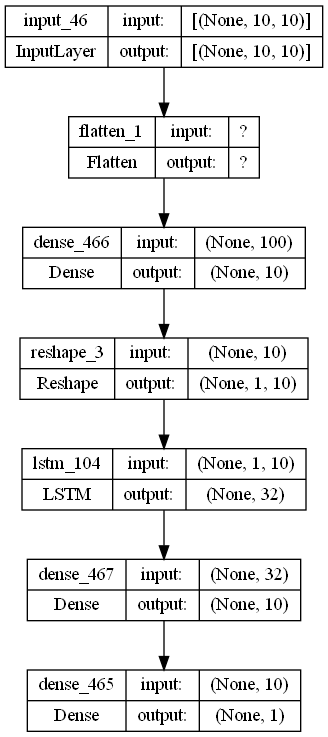

In [265]:
# Plot the model architecture
plot_model(combined_model, to_file='combined_model.png', show_shapes=True)

In [194]:
import numpy as np
import tensorflow as tf

encoding_dim = 10
num_hidden = 10
num_features = 10
num_filters = 16
num_units = 32

# Define the autoencoder to encode each feature
input_shape = (10,)  # N is the number of input features

encoder = tf.keras.layers.Dense(units=10, activation='relu', input_shape=input_shape)
first_hidden_layer = tf.keras.layers.Dense(units=6, activation='relu')
decoder = tf.keras.layers.Dense(units=10, activation='sigmoid')

autoencoder = tf.keras.Sequential([encoder, first_hidden_layer, decoder])

# Load the pre-trained CNN
CNN = tf.keras.models.load_model('pre_trained_model.h5')

# Freeze all layers in CNN
CNN.trainable = False

V = np.zeros((num_features, num_hidden))

# 1st for loop: Encoding
for i in range(num_features):
    V[i] = autoencoder.predict(X_train_resampled_final[i:i+1])[0][0:encoding_dim]

C = CNN(V)
C = np.expand_dims(C, axis=0)  # Add a new dimension to C
C = np.repeat(C, num_features, axis=0)  # Repeat C num_features times

# Define the LSTM layer with the appropriate input shape
LSTM = tf.keras.layers.LSTM(units=num_units, use_bias=True, kernel_initializer="glorot_uniform", input_shape=(1, num_hidden))

# Reshape V to have shape (num_features, 1, num_hidden) to add the timesteps dimension
V = np.reshape(V, (num_features, 1, num_hidden))

# Pass the vector representations through the LSTM layer
O = LSTM(V)

# Define the final classification layer
FL = tf.keras.layers.Dense(units=1, activation='sigmoid')

# Connect it to the output of the LSTM layer
O = FL(O)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 0s 34ms/step


In [175]:
autoencoder.summary()

Model: "sequential_188"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_382 (Dense)           (None, 10)                110       
                                                                 
 dense_383 (Dense)           (None, 6)                 66        
                                                                 
 dense_384 (Dense)           (None, 10)                70        
                                                                 
Total params: 246
Trainable params: 246
Non-trainable params: 0
_________________________________________________________________


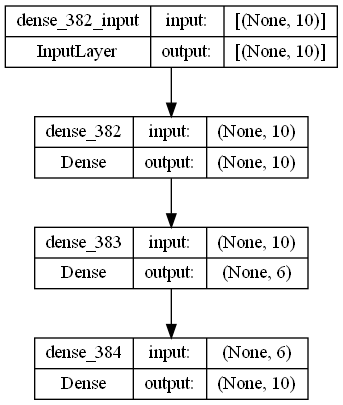

In [179]:
# Plot the model architecture
plot_model(autoencoder, to_file='auto.png', show_shapes=True)

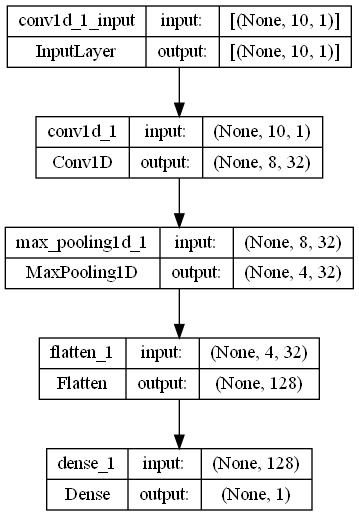

In [180]:
# Plot the model architecture
plot_model(CNN, to_file='cnn.png', show_shapes=True)

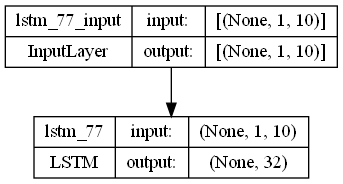

In [178]:
from tensorflow.keras.utils import plot_model

# Build the model
model = tf.keras.Sequential([LSTM])
model.build(input_shape=(None, 1, num_hidden))

# Plot the model architecture
plot_model(model, to_file='lstm.png', show_shapes=True)

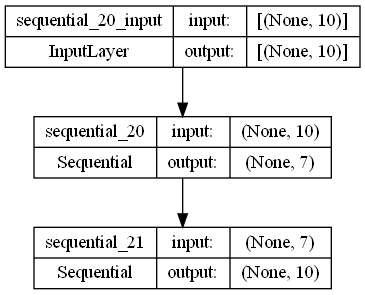

In [43]:
from keras.utils import plot_model
plot_model(autoencoder, to_file='autoencoder_last.png', show_shapes=True)

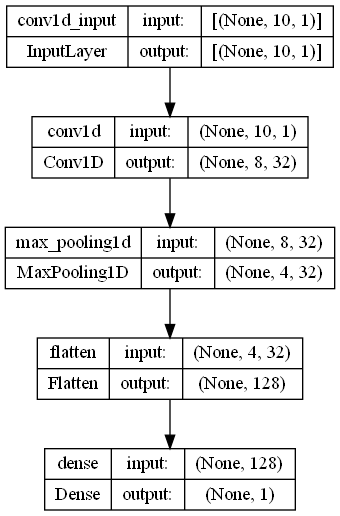

In [45]:
from keras.utils import plot_model
plot_model(pre_trained_model, to_file='pre_trained_cnn.png', show_shapes=True)

# Hyperparameter tuning

In [ ]:
# from keras.models import Sequential
# from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
# from keras.wrappers.scikit_learn import KerasClassifier
# from sklearn.model_selection import GridSearchCV

# def create_model(filters=32, kernel_size=3, activation='tanh', dropout_rate=0.2, loss='binary_crossentropy', opt='adam'):
#     model = Sequential()
#     model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation=activation, input_shape=(10, 1)))
#     model.add(MaxPooling1D(pool_size=2))
#     model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation=activation))
#     model.add(MaxPooling1D(pool_size=2))
#     model.add(Flatten())
#     model.add(Dense(64, activation=activation))
#     model.add(Dropout(dropout_rate))
#     model.add(Dense(1, activation='sigmoid'))
    
#     model.compile(loss=loss, optimizer=opt, metrics=['accuracy'])
#     return model

# keras_model = KerasClassifier(build_fn=create_model, verbose=1)

# param_grid = {
#     'filters': [16, 32, 64],
#     'kernel_size': [3, 5],
#     'activation': ['tanh', 'relu'],
#     'dropout_rate': [0.2, 0.5],
#     'loss': ['binary_crossentropy', 'mse'],
#     'opt': ['adam', 'sgd']
# }

# grid = GridSearchCV(estimator=keras_model, param_grid=param_grid, cv=3)
# grid_result = grid.fit(X_train_resampled_final, y_train_resampled_final)

In [ ]:
# from keras.models import Sequential
# from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
# from keras.wrappers.scikit_learn import KerasClassifier
# from sklearn.model_selection import RandomizedSearchCV
# from scipy.stats import randint

# def create_model(filters=32, kernel_size=3, activation='tanh', dropout_rate=0.2, loss='binary_crossentropy', opt='adam'):
#     model = Sequential()
#     model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation=activation, input_shape=(10, 1)))
#     model.add(MaxPooling1D(pool_size=2))
#     model.add(Dense(1, activation='sigmoid'))
#     model.add(Dropout(dropout_rate))
#     model.add(Flatten())
#     model.compile(loss=loss, optimizer=opt, metrics=['accuracy'])
#     return model

# keras_model = KerasClassifier(build_fn=create_model, verbose=1)

# param_dist = {
#     'filters': randint(16, 64),
#     'kernel_size': [3, 5],
#     'activation': ['tanh', 'relu'],
#     'dropout_rate': [0.2, 0.5],
# }

# n_iter_search = 10
# random_search = RandomizedSearchCV(estimator=keras_model, param_distributions=param_dist, n_iter=n_iter_search, cv=3)
# random_search_result = random_search.fit(X_train_resampled_final, y_train_resampled_final)
# print("Best hyperparameters: ", random_search_result.best_params_)

In [ ]:
# from keras.layers import Input, Conv1D, LSTM, Dense, Activation
# from keras.models import Model

# # Define input shape
# n_features = 10  # number of input features
# input_shape = (None, n_features)

# # Define input layer
# inputs = Input(shape=input_shape)

# # Define autoencoder to encode input features
# encoded_features = []
# for i in range(n_features):
#     feature_input = Input(shape=(1,))
#     encoded = Dense(32, activation='relu')(feature_input)
#     decoded = Dense(1, activation='linear')(encoded)
#     autoencoder = Model(feature_input, decoded)
#     autoencoder.compile(optimizer='adam', loss='mse')
#     autoencoder.fit(X_train_resampled_final[:,i], X_train_resampled_final[:,i], epochs=1, batch_size=32)
#     encoded_feature_i = autoencoder.predict(X_train_resampled_final[:,i].reshape(-1, 1))
#     encoded_features.append(encoded_feature_i)

# # Convolutional layer to extract relevant features
# conv_layer = Conv1D(filters=32, kernel_size=3, padding='same')(encoded_features)

# # LSTM layer to capture temporal dependencies
# lstm_layer = LSTM(units=64, return_sequences=True)(conv_layer)

# # Fully connected layer with ReLU activation function
# fc_layer = Dense(units=128, activation='relu')(lstm_layer)

# # Output layer with sigmoid activation function
# output_layer = Dense(units=1, activation='sigmoid')(fc_layer)

# # Define model
# model = Model(inputs=inputs, outputs=output_layer)

# # Compile model
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # Train model
# model.fit(x_train, y_train, epochs=1, batch_size=32)

# # Evaluate model
# score = model.evaluate(x_test, y_test, verbose=0)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])

# New CNN

In [ ]:
from keras.layers import Lambda
from keras import backend as K
from sklearn.model_selection import StratifiedKFold
import numpy as np
from keras import regularizers
import matplotlib.pyplot as plt

input_dim = 10

# Define a custom scaling function
def scale(x):
    mean = K.mean(x)
    std = K.std(x)
    return (x - mean) / std

# Create K-fold cross-validator
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Initialize lists to store training and validation loss for each fold
train_loss = []
val_loss = []

# Loop over each fold
for fold, (train_index, val_index) in enumerate(kfold.split(X_train_resampled_final, y_train_resampled_final)):
    print(f'Fold {fold + 1}...')
    
    # Split data into training and validation sets for this fold
    X_train_fold = X_train_resampled_final.iloc[train_index]
    y_train_fold = y_train_resampled_final.iloc[train_index]
    X_val_fold = X_train_resampled_final.iloc[val_index]
    y_val_fold = y_train_resampled_final.iloc[val_index]
    
    # Create model
    model_new = Sequential()
    model_new.add(Lambda(scale, input_shape=(input_dim,)))
    model_new.add(Dense(32, activation='tanh', kernel_regularizer=regularizers.l1(0.000811)))
    model_new.add(Dense(1, activation='sigmoid'))
    opt_new = Adam(lr=0.00033)
    model_new.compile(loss='binary_crossentropy', optimizer=opt_new, metrics=['accuracy'])
    
    # Train model on this fold's training data
    history = model_new.fit(X_train_fold, y_train_fold, epochs=10, batch_size=32, verbose=1, validation_data=(X_val_fold, y_val_fold))
    
    # Append this fold's training and validation loss to the lists
    train_loss.append(history.history['loss'])
    val_loss.append(history.history['val_loss'])
    
    # Plot this fold's training and validation loss
    plt.plot(history.history['loss'], label=f'Fold {fold + 1} Training Loss')
    plt.plot(history.history['val_loss'], label=f'Fold {fold + 1} Validation Loss')
    
# Plot the average training and validation loss across all folds
plt.plot(np.mean(train_loss, axis=0), label='Average Training Loss', color='black', linewidth=2)
plt.plot(np.mean(val_loss, axis=0), label='Average Validation Loss', color='red', linewidth=2)

# Add labels and legend to the plot
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Across Folds')
plt.legend()
plt.show()

## Transfer learning

In [ ]:
pre_trained_model.save('pre_trained_model.h5')

In [ ]:
from keras.models import load_model

pre_trained_model = load_model('pretrained_model.h5')

## Extract learnt weights

In [ ]:
cnn_weights = pre_trained_model.layers[2].get_weights()

## Transfer learnt weights to the new CNN

In [ ]:
model_new.layers[0].set_weights(cnn_weights)

## Create LSTM

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout

# Define LSTM model
LSTM_model = Sequential()
LSTM_model.add(LSTM(units=50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2,input_shape=(X_train_resampled_final.shape[1], 1))
        )
# Add drop out layer
LSTM_model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2))
LSTM_model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
LSTM_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
LSTM_model.fit(X_train_resampled_final, y_train_resampled_final, epochs=10, batch_size=32)

In [ ]:
score = LSTM_model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# New steps

In [ ]:
# Pre-train CNN model
pretrained_cnn = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

pretrained_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
pretrained_cnn.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test))

# Transfer learning to create new CNN
new_cnn = Sequential(pretrained_cnn.layers[:-2])
for layer in new_cnn.layers:
    layer.trainable = False

    
# The TimeDistributed layer is used to apply the same CNN layers to every time step of the input sequence. The output of this layer is 
# then passed to an LSTM layer, which is followed by a Dense layer with a softmax activation function to predict the class labels.
# Add RNN layers to create CNN-RNN model
cnn_rnn = Sequential([
    TimeDistributed(new_cnn, input_shape=input_shape),
    LSTM(64),
    Dense(num_classes, activation='softmax')
])

# Train CNN-RNN model
cnn_rnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_rnn.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test))

# Thaw CNN model
for layer in new_cnn.layers:
    layer.trainable = True

# Add attention layer
attention = Sequential([
    Dense(1, activation='tanh'),
    Flatten(),
    Activation('softmax')
])
cnn_rnn_attention = Sequential([
    TimeDistributed(new_cnn, input_shape=input_shape),
    LSTM(64, return_sequences=True),
    TimeDistributed(attention),
    Dot(axes=1),
    Flatten(),
    Dense(num_classes, activation='softmax')
])

# Train CNN-RNN-Attention model
cnn_rnn_attention.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_rnn_attention.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test))

## Soidisant feature fusion

https://www.bing.com/videos/search?&q=feature+fusion+deep+learning&docid=603484746686478091&mid=ED175C063F17E1FDCFCEED175C063F17E1FDCFCE&view=detail&FORM=VDRVRV&rvsmid=083DA2472C6F7DD33EE1083DA2472C6F7DD33EE1&ajaxhist=0


In [ ]:
from keras.layers import concatenate

# Pre-train CNN model
pretrained_cnn = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

pretrained_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
pretrained_cnn.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test))

# Transfer learning to create new CNN
new_cnn = Sequential(pretrained_cnn.layers[:-2])
for layer in new_cnn.layers:
    layer.trainable = False

# Add RNN layers to create CNN-RNN model
cnn_rnn = Sequential([
    TimeDistributed(new_cnn, input_shape=input_shape),
    LSTM(64, return_sequences=True),
    Flatten()
])

# Add merge layer
merged = concatenate([cnn_rnn.output, new_cnn.output])

# Add dense layer for classification
output_layer = Dense(num_classes, activation='softmax')(merged)

# Create model
model = Model(inputs=[cnn_rnn.input, new_cnn.input], outputs=output_layer)

# Train model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit([x_train, x_train], y_train, batch_size=batch_size, epochs=epochs, validation_data=([x_test, x_test], y_test))


In [ ]:
import numpy as np
import pandas as pd

# Define the objective function
def objective_function(X, y):
    # Initialize theta with zeros
    n_features = X.shape[1]
    theta = np.zeros(n_features)
    
    m = len(y)
    h = sigmoid(np.dot(X, theta))
    J = -1/m * np.sum(y*np.log(h) + (1-y)*np.log(1-h))
    return J

# Define the MBOA function
def MBOA(dim, maxiter, Bf, c, a, p, x,y):
    # Initialization

    n = len(df.columns)
    X = np.random.rand(n, dim)
    I = np.zeros(n)
    F = np.zeros(n)

    # Step 1: Set the initial generation/iteration number G=0
    G = 0

    # Step 2: Generate initial population of n butterflies 𝑋𝑖 = (i=1,2,..,n)

    # define the size of the population
    n = 10000

    # extract the variables of interest
    variables = X_train_resampled_final.iloc[:, :dim]

    # define the ranges for each variable
    ranges = [(0, 10000)]*dim

    # generate the initial population
    population = []
    for i in range(n):
        butterfly = []
        for j in range(variables.shape[0]):
            var_range = ranges[j]
            var_value = np.random.uniform(var_range[0], var_range[1])
            butterfly.append(var_value)
        population.append(butterfly)


    # Main loop
    while G < maxiter:
        # Calculate stimulus intensity for each butterfly
        for i in range(Bf):
            I[i] = objective_function(X[:, i], y)
            F[i] = c * I[i]**a

        # Find the best butterfly
        best_butterfly = X[:, np.argmin(I)]

        # Update each butterfly in the population
        for i in range(n):
            r = np.random.rand()
            if r < p:
                # Move towards the best butterfly
                X[:, i] += np.random.rand(dim) * (best_butterfly - X[:, i])
                # Determine mutual relationship vector and update butterfly positions
                j = np.random.randint(n)
                if i != j:
                    MutualVector = (X[:, i] - X[:, j]) / np.linalg.norm(X[:, i] - X[:, j])
                    X[:, i] += np.random.rand(dim) * MutualVector
                    X[:, j] += np.random.rand(dim) * MutualVector
                   # Calculate fitness value of the new butterfly
                    I[i] = fitness(X[:, i], fun)
                    # Update the best butterfly if a new one is found
                    if I[i] < best_fitness:
                        best_butterfly = X[:, i]
                        best_fitness = I[i]

                    # Update the mutation probability
                    p = p * alpha

                    # Store the best fitness value of this iteration
                    best_fitness_values.append(best_fitness)


    # Return the best butterfly and its fitness value
    return best_butterfly, best_fitness, best_fitness_values

## Freeze layer in NEW CNN (DO NOT FREEZE IN PRE-TRAINED CNN): To be done b4 training NN

In [ ]:
# Freeze all layers in the pre-trained model
for layer in model_new.layers:
    layer.trainable = False

In [ ]:
import numpy as np
import pandas as pd

# Define the objective function
def objective_function(X, y):
    # Initialize theta with zeros
    n_features = X.shape[1]
    theta = np.zeros(n_features)
    
    m = len(y)
    h = sigmoid(np.dot(X, theta))
    J = -1/m * np.sum(y*np.log(h) + (1-y)*np.log(1-h))
    return J

# Define the MBOA function
def MBOA(dim, maxiter, Bf, c, a, p, x, y):
    
    # Initialization
    
    I = np.zeros(Bf)
    F = np.zeros(Bf)
    best_fitness_values = []
    
    # Step 1: Set the initial generation/iteration number G=0
    G = 0
    
    # Step 2: Generate initial population of n butterflies 𝑋𝑖 = (i=1,2,..,n)
    
    # define the size of the population
    n = 10000

    # extract the variables of interest
    variables = X_train_resampled_final.iloc[:, :dim]

    # define the ranges for each variable
    ranges = [(0, 10000)]*dim

    # generate the initial population
    population = []
    for i in range(n):
        butterfly = []
        for j in range(variables.shape[0]):
            var_range = ranges[j]
            var_value = np.random.uniform(var_range[0], var_range[1])
            butterfly.append(var_value)
        population.append(butterfly)


    # Main loop
    while G < maxiter:
        # Calculate stimulus intensity for each butterfly
        for i in range(Bf):
            I[i] = objective_function(X[:, i], y)
            F[i] = c * I[i]**a
        
        # Find the best butterfly
        best_butterfly = X[:, np.argmin(I)]

        # Update each butterfly in the population
        for i in range(n):
            r = np.random.rand()
            if r < p:
                # Move towards the best butterfly
                X[:, i] += np.random.rand(dim) * (best_butterfly - X[:, i])
                # Determine mutual relationship vector and update butterfly positions
                j = np.random.randint(n)
                if i != j:
                    MutualVector = (X[:, i] - X[:, j]) / np.linalg.norm(X[:, i] - X[:, j])
                    X[:, i] += np.random.rand(dim) * MutualVector
                    X[:, j] += np.random.rand(dim) * MutualVector
                   # Calculate fitness value of the new butterfly
                    I[i] = fitness(X[:, i], fun)
                    # Update the best butterfly if a new one is found
                    if I[i] < best_fitness:
                        best_butterfly = X[:, i]
                        best_fitness = I[i]

                    # Update the mutation probability
                    p = p * alpha

                    # Store the best fitness value of this iteration
                    best_fitness_values.append(best_fitness)

        # Increment the generation number
        G += 1


    # Return the best butterfly and its fitness value
    return best_butterfly, best_fitness, best_fitness_values

# Call the function
best_butterfly, best_fitness = MBOA(objective_function, 5, 50, 10, 1, 2, 0.8, X_train_resampled_final)

# Print the best butterfly and its fitness value
print("Best butterfly:", best_butterfly)
print("Fitness value of best butterfly:", best_fitness)

In [ ]:
import random
import math

# Objective function
def f(X):
    return sum([x**2 for x in X])

# Butterfly Optimization Algorithm
def butterfly_optimization(f, dim, Maxiter, Bf, c, a, p):
    
    # Initialize
    
    # Set the initial generation/iteration number G=0
    
    G = 0
    n = Bf
    
    # Generate initial population of n butterflies 𝑋𝑖 = (i=1,2,..,n)
    
    X = [[random.uniform(-5,5) for _ in range(dim)] for _ in range(n)]
    I = [f(x) for x in X]
    best_index = I.index(min(I))
    best = X[best_index]
    while G < Maxiter:
        # Calculate fragrance
        F = [c * I[i]**a for i in range(n)]
        # Find the best butterfly
        best_index = F.index(max(F))
        best = X[best_index]
        # Update each butterfly
        for i in range(n):
            # Move towards best butterfly
            if random.random() < p:
                for j in range(dim):
                    X[i][j] += random.uniform(-1,1) * abs(best[j] - X[i][j])
            # Mutual relationship
            else:
                j = random.randint(0,n-1)
                while j == i:
                    j = random.randint(0,n-1)
                MutVect = [random.uniform(-1,1) for _ in range(dim)]
                # Collaboration strategy
                X[i] = [X[i][k] + random.uniform(0,1) * MutVect[k] * abs(X[j][k] - X[i][k]) for k in range(dim)]
            # Update fitness value
            I[i] = f(X[i])
        # Update the best value
        if min(I) < f(best):
            best_index = I.index(min(I))
            best = X[best_index]
        G += 1
    return best, f(best)

# Call the function
best_butterfly, best_fitness = butterfly_optimization(f, dim=5, Maxiter=50, Bf=10, c=1, a=2, p=0.8)

# Print the best butterfly and its fitness value
print("Best butterfly:", best_butterfly)
print("Fitness value of best butterfly:", best_fitness)

In [ ]:
# # Butterfly Optimization Algorithm
# def butterfly_optimization(f, dim, Maxiter, Bf, c, a, p, X_train):
#     # Initialize
#     G = 0
#     n = Bf
#     if len(X_train) < n:
#         n = len(X_train)
    
#     X = [X_train[i] for i in range(n)]
    
#     I = [f(x) for x in X]
#     best_index = I.index(min(I))
#     best = X[best_index]
#     while G < Maxiter:
#         # Calculate fragrance
#         F = [c * I[i]**a for i in range(n)]
#         # Find the best butterfly
#         best_index = F.index(max(F))
#         best = X[best_index]
#         # Update each butterfly
#         for i in range(n):
#             # Move towards best butterfly
#             if random.random() < p:
#                 for j in range(dim):
#                     X[i][j] += random.uniform(-1,1) * abs(best[j] - X[i][j])
#             # Mutual relationship
#             else:
#                 j = random.randint(0,n-1)
#                 while j == i:
#                     j = random.randint(0,n-1)
#                 MutVect = [random.uniform(-1,1) for _ in range(dim)]
#                 # Collaboration strategy
#                 X[i] = [X[i][k] + random.uniform(0,1) * MutVect[k] * abs(X[j][k] - X[i][k]) for k in range(dim)]
#             # Update fitness value
#             I[i] = f(X[i])
#         # Update the best value
#         if min(I) < f(best):
#             best_index = I.index(min(I))
#             best = X[best_index]
#         G += 1
#     return best, f(best)

# # X_train_resampled_final = X_train_resampled_final.values.tolist()

# # Call the function
# best_butterfly, best_fitness = butterfly_optimization(f, dim=5, Maxiter=50, Bf=10, c=1, a=2, p=0.8, X_train=X_train_resampled_final)

# # Print the best butterfly and its fitness value
# print("Best butterfly:", best_butterfly)
# print("Fitness value of best butterfly:", best_fitness)

# Work refinement

In [ ]:
# Objective function
def f(X):
    return sum([x**2 for x in X])

def butterfly_optimization(f, X, Maxiter, Bf, c, a, p):
    
    # Initialization
    
    n = len(X) # Obtain length of X_train_resampled_final
    print("n",n)
    
    dim = len(X[0])
    print("dim",dim)
    
    I = [f(x) for x in X]
    best_index = I.index(min(I))
    best = X[best_index]
    G = 0
    while G < Maxiter:
        # Calculate fragrance
        F = [c * I[i]**a for i in range(n)]
        # Find the best butterfly
        best_index = F.index(max(F))
        best = X[best_index]
        # Update each butterfly
        for i in range(n):
            # Move towards best butterfly
            if random.random() < p:
                for j in range(dim):
                    X[i][j] += random.uniform(-1,1) * abs(best[j] - X[i][j])
            # Mutual relationship
            else:
                j = random.randint(0,n-1)
                while j == i:
                    j = random.randint(0,n-1)
                MutVect = [random.uniform(-1,1) for _ in range(dim)]
                # Collaboration strategy
                X[i] = [X[i][k] + random.uniform(0,1) * MutVect[k] * abs(X[j][k] - X[i][k]) for k in range(dim)]
            # Update fitness value
            I[i] = f(X[i])
        # Update the best value
        if min(I) < f(best):
            best_index = I.index(min(I))
            best = X[best_index]
        G += 1
    return best, f(best)

# Convert Pandas DataFrame to list of lists
X_train_resampled_final_list = X_train_resampled_final.values.tolist()

# Call the function with the modified input data
best_butterfly, best_fitness = butterfly_optimization(f, X_train_resampled_final_list, Maxiter=3, Bf=10, c=1, a=2, p=0.8)

# Print the best butterfly and its fitness value
print("Best butterfly:", best_butterfly)
print("Fitness value of best butterfly:", best_fitness)

# Current

In [ ]:
import random
import math

# @ Input 1: Objective function

def f(X):
    return sum([x**2 for x in X])

# @ Input 2: 𝑋𝑖 = (𝑋1, 𝑋2,𝑋3, … … , 𝑋𝑑𝑖𝑚),

# X_train_resampled_final_list = X_train_resampled_final.tolist()
X_train_resampled_final_list = X_train_resampled_final.values.tolist()

def butterfly_optimization(f, X, Maxiter, Bf, c, a, p):
    
    # Initialization
    
    n = len(X) # Obtain length of X_train_resampled_final
    
    # @ Input 3: dim= no. of dimensions 

    dim = len(X[0])
    
    I = [f(x) for x in X]
    
    best_index = I.index(min(I))
    
    best = X[best_index]
    
    G = 0
    
    while G < Maxiter:
        
        # Calculate fragrance
        F = [c * I[i]**a for i in range(n)] # Equation(8)
        
        print(type(F))

        # Find the best butterfly
        best_index = F.index(max(F))
        best = X[best_index]
        
        # Update each butterfly
        
        for i in range(n):
            
            # Move towards best butterfly
            if random.random() < p:
                for j in range(dim):
                    #X[i][j] += random.uniform(-1,1) * abs(best[j] - X[i][j]) # Equation (9)
                    X[i][j] += random.uniform(-1,1) * abs(best[j] - X[i][j]) # Equation (9)
                    #X[i][j] += pow(random.uniform(-1, 1),2) * abs(best[j] - X[i][j]) * F[i]

            # Mutual relationship
            else:
                j = random.randint(0,n-1)
                while j == i:
                    j = random.randint(0,n-1)
                MutVect = [random.uniform(-1,1) for _ in range(dim)]
                
                # Collaboration strategy
                X[i] = [X[i][k] + random.uniform(0,1) * MutVect[k] * abs(X[j][k] - X[i][k]) for k in range(dim)]
            # Update fitness value
            I[i] = f(X[i])
        # Update the best value
        if min(I) < f(best):
            best_index = I.index(min(I))
            best = X[best_index]
        G += 1
    return best, f(best)

    
# Call the function with the modified input data
# Define sensor modality c, power exponent a and switch probability p 
best_butterfly, best_fitness = butterfly_optimization(f, X_train_resampled_final_list, Maxiter=3, Bf=10, c=1, a=2, p=0.8)

# Print the best butterfly and its fitness value
print("Best butterfly:", best_butterfly)
print("Fitness value of best butterfly:", best_fitness)

In [ ]:
import random
import decimal
import math
from sklearn.feature_selection import mutual_info_classif

def f(X):
    # Calculate the mutual information between each feature and the target variable
    scores = mutual_info_classif(X, y_train_resampled)
    # Return the sum of the scores as the fitness value
    return sum(scores)

def butterfly_optimization(X, y, Maxiter, Bf, c, a, p):
    n = len(X)
    dim = X.shape[1]
    decimal.getcontext().prec = 28 # Set the precision of the decimal module
    X = [[decimal.Decimal(str(X[i][j])) for j in range(dim)] for i in range(n)] # Convert all values to Decimal
    #F = [decimal.Decimal(random.uniform(0, 1)) for i in range(n)]
    F = [c * I[i]**a for i in range(n)]
    fitness = [mutual_info_classif(X[i], y)[0] for i in range(n)]
    best = X[fitness.index(max(fitness))]
    best_fitness = max(fitness)
    for t in range(Maxiter):
        for i in range(n):
            eps = decimal.Decimal(random.gauss(0, 1))
            for j in range(dim):
                X[i][j] += eps * F[i] * abs(best[j] - X[i][j])
            score = mutual_info_classif(X[i], y)[0]
            if score > fitness[i]:
                fitness[i] = score
                if score > best_fitness:
                    best_fitness = score
                    best = X[i]
            r = random.uniform(0, 1)
            if r < p:
                for j in range(dim):
                    X[i][j] += decimal.Decimal(pow(float(r), 2)) * abs(best[j] - X[i][j]) * F[i]
            else:
                j = random.randint(0, n-1)
                for k in range(dim):
                    X[i][k] += decimal.Decimal(pow(float(r), 2)) * abs(X[j][k] - X[i][k]) * F[i]
            for j in range(dim):
                X[i][j] = max(X[i][j], decimal.Decimal(-Bf))
                X[i][j] = min(X[i][j], decimal.Decimal(Bf))
            F[i] = decimal.Decimal(c) / decimal.Decimal(pow((1 + a * t), 1.5))
    best = [float(best[i]) for i in range(dim)] # Convert best values back to float
    return best, best_fitness

# Print the best butterfly and its fitness value
print("Best butterfly:", best_butterfly)
print("Fitness value of best butterfly:", best_fitness)

In [ ]:
import random
import decimal
import math
from sklearn.feature_selection import mutual_info_classif

def f(X):
    # Calculate the mutual information between each feature and the target variable
    scores = mutual_info_classif(X, y_train_resampled)
    # Return the sum of the scores as the fitness value
    return sum(scores)

def butterfly_optimization(X, y, Maxiter, Bf, c, a, p):
    n = len(X)
    dim = X.shape[1]
    decimal.getcontext().prec = 28 # Set the precision of the decimal module
    X = [[decimal.Decimal(str(X[i][j])) for j in range(dim)] for i in range(n)] # Convert all values to Decimal
    #F = [decimal.Decimal(random.uniform(0, 1)) for i in range(n)]
    F = [c * I[i]**a for i in range(n)]
    fitness = [mutual_info_classif(X[i], y)[0] for i in range(n)]
    best = X[fitness.index(max(fitness))]
    best_fitness = max(fitness)
    for t in range(Maxiter):
        for i in range(n):
            eps = decimal.Decimal(random.gauss(0, 1))
            for j in range(dim):
                X[i][j] += eps * F[i] * abs(best[j] - X[i][j])
            score = mutual_info_classif(X[i], y)[0]
            if score > fitness[i]:
                fitness[i] = score
                if score > best_fitness:
                    best_fitness = score
                    best = X[i]
            r = random.uniform(0, 1)
            if r < p:
                for j in range(dim):
                    X[i][j] += decimal.Decimal(pow(float(r), 2)) * abs(best[j] - X[i][j]) * F[i]
            else:
                j = random.randint(0, n-1)
                for k in range(dim):
                    X[i][k] += decimal.Decimal(pow(float(r), 2)) * abs(X[j][k] - X[i][k]) * F[i]
            for j in range(dim):
                X[i][j] = max(X[i][j], decimal.Decimal(-Bf))
                X[i][j] = min(X[i][j], decimal.Decimal(Bf))
            F[i] = decimal.Decimal(c) / decimal.Decimal(pow((1 + a * t), 1.5))
    best = [float(best[i]) for i in range(dim)] # Convert best values back to float
    return best, best_fitness

# Call the function with the modified input data
# Define sensor modality c, power exponent a and switch probability p 
best_butterfly, best_fitness = butterfly_optimization(f, X_train_resampled_final_list, Maxiter=3, Bf=10, c=1, a=2, p=0.8)
# Print the best butterfly and its fitness value
print("Best butterfly:", best_butterfly)
print("Fitness value of best butterfly:", best_fitness)

In [ ]:
import random
import decimal
import math

# Objective function: Sphere function
def f(X):
    return sum([x**2 for x in X])

# # Rosenbrock
# def f(X):
#     # return sum([100 * (X[i+1] - X[i]**2)**2 + (1 - X[i])**2 for i in range(len(X)-1)])
    
#     f(x,y)=(1-x)^2+100(y-x^2)^2 

def butterfly_optimization(X, y, Maxiter, Bf, c, a, p):
    
    dim =10
    n=10
    
    decimal.getcontext().prec = 28 # Set the precision of the decimal module
    
    # calculate initial stimulus intensity for each butterfly
    I = np.zeros(Bf)
    for i in range(Bf):
        I[i] = f(X[i])
        
    #I = [f(x) for x in X]
    
    X = [[decimal.Decimal(str(X[i][j])) for j in range(dim)] for i in range(n)] # Convert all values to Decimal
    
    #F = [decimal.Decimal(random.uniform(0, 1)) for i in range(n)]
    F = [decimal.Decimal(c) * decimal.Decimal(I[i])** decimal.Decimal(a) for i in range(n)]

    # Find the best butterfly
    best_index = F.index(max(F))
    best = X[best_index]
    
    # Set the initial generation/iteration number G=0
    G=0
    #for G in range(Maxiter):
    while G < Maxiter:
        for i in range(Bf):
                    
            # Generate a random number r from [0,1]
            r = random.uniform(0, 1)
            if r < p:
                for j in range(dim):
                    X[i][j] += decimal.Decimal(pow(float(r), 2)) * abs(best[j] - X[i][j]) * F[i]
            else:
                j = random.randint(0, n-1)
                for k in range(dim):
                    X[i][k] += decimal.Decimal(pow(float(r), 2)) * abs(X[j][k] - X[i][k]) * F[i]
            for j in range(dim):
                X[i][j] = max(X[i][j], decimal.Decimal(-Bf))
                X[i][j] = min(X[i][j], decimal.Decimal(Bf))
            F[i] = decimal.Decimal(c) / decimal.Decimal(pow((1 + a * G), 1.5))
            G=G+1
    best = [float(best[i]) for i in range(dim)] # Convert best values back to float
    return best, best_fitness

# Call the function with the modified input data
# Define sensor modality c, power exponent a and switch probability p 
best_butterfly, best_fitness = butterfly_optimization(X_train_resampled_final_list, y_train_resampled, Maxiter=1000, Bf=10, c=3, a=4, p=0.85)

# Print the best butterfly and its fitness value
print("Best butterfly:", best_butterfly)
print("Fitness value of best butterfly:", best_fitness)

# Print the values of the best butterfly to check if they are close to zero
print("Values of best butterfly:", [round(x, 5) for x in best_butterfly])

In [ ]:
import random
import decimal
import math

# Objective function: KNN classification with feature selection
# def fitness(X, y, k=5, alpha=0.5):
#     # X: feature matrix (num_samples x num_features)
#     # y: target vector (num_samples,)
#     # k: number of nearest neighbors to consider in KNN
#     # alpha: importance of classification quality vs subset length (0 <= alpha <= 1)
    
#     from sklearn.neighbors import KNeighborsClassifier
#     from sklearn.metrics import accuracy_score
    
#     clf = KNeighborsClassifier(n_neighbors=k)
#     clf.fit(X, y)
    
#     # Calculate classification error rate
#     y_pred = clf.predict(X)
#     error_rate = 1 - accuracy_score(y, y_pred)
    
#     # Calculate fitness
#     num_selected = X.shape[1]
#     num_total = X.shape[1]
#     fitness_value = alpha * (1 - error_rate) + (1 - alpha) * (num_selected / num_total)
    
#     return fitness_value

def fitness(X, y, k=5, alpha=0.5):
    # X: feature matrix (num_samples x num_features)
    # y: target vector (num_samples,)
    # k: number of nearest neighbors to consider in KNN
    # alpha: importance of classification quality vs subset length (0 <= alpha <= 1)

    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.metrics import accuracy_score

    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X, y)

    # Calculate classification error rate
    y_pred = clf.predict(X)
    error_rate = 1 - accuracy_score(y, y_pred)

    # Calculate fitness
    num_selected = X.shape[1]
    num_total = X.shape[1]
    fitness_value = alpha * (1 - error_rate) + (1 - alpha) * (num_selected / num_total)

    return fitness_value

def butterfly_optimization(X, y, Maxiter, Bf, c, a, p):
    
    dim = X.shape[1]
    n = Bf
    
    decimal.getcontext().prec = 28 # Set the precision of the decimal module
    
    # Initialize butterfly positions and calculate initial stimulus intensity for each butterfly
    X = [[decimal.Decimal(str(X[i][j])) for j in range(dim)] for i in range(n)]
    I = [fitness(X[i], y) for i in range(n)]
    
    # Initialize stimulus strength and find the best butterfly
    F = [decimal.Decimal(c) * decimal.Decimal(I[i])**decimal.Decimal(a) for i in range(n)]
    best_index = I.index(max(I))
    best = X[best_index]
    best_fitness = I[best_index]
    
    # Set the initial generation/iteration number G=0
    G=0
    while G < Maxiter:
        for i in range(Bf):
                    
            # Generate a random number r from [0,1]
            r = random.uniform(0, 1)
            if r < p:
                for j in range(dim):
                    X[i][j] += decimal.Decimal(pow(float(r), 2)) * abs(best[j] - X[i][j]) * F[i]
            else:
                j = random.randint(0, n-1)
                for k in range(dim):
                    X[i][k] += decimal.Decimal(pow(float(r), 2)) * abs(X[j][k] - X[i][k]) * F[i]
            for j in range(dim):
                X[i][j] = max(X[i][j], decimal.Decimal(-Bf))
                X[i][j] = min(X[i][j], decimal.Decimal(Bf))
            I[i] = fitness(X[i], y)
            if I[i] > best_fitness:
                best = X[i]
                best_fitness = I[i]
            F[i] = decimal.Decimal(c) / decimal.Decimal(pow((1 + a * G), 1.5))
            G=G+1
    best = [float(best[i]) for i in range(dim)] # Convert best values back to float
    return best, best_fitness

best_butterfly, best_fitness = butterfly_optimization(X_train_resampled_final, y_train_resampled_final, Maxiter=30, Bf=10, c=3, a=1, p=0.5)

# Print the best butterfly and its fitness value
print("Best butterfly:", best_butterfly)
print("Fitness value of best butterfly:", best_fitness)

# Print the values of the best butterfly to check if they are close to zero
print("Values of best butterfly:", [round(x, 5) for x in best_butterfly])

In [ ]:
import random
import decimal
import math
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

def butterfly_optimization(X, y, Maxiter, Bf, c, a, p):
    
    dim = X.shape[1]
    n = X.shape[0]
    decimal.getcontext().prec = 28 # Set the precision of the decimal module
    
    # Load the KNN classifier
    clf = KNeighborsClassifier(n_neighbors=5)
    
    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y)
        
    # calculate initial stimulus intensity for each butterfly
#     I = np.zeros(Bf)
#     for i in range(Bf):
#         I[i] = f(X[i])
     # In the butterfly optimization function, modify the calculation of initial stimulus intensity for each butterfly to include the fitness function
    I = np.zeros(Bf)
    for i in range(Bf):
         I[i] = fitness(X[i], y, k)
    X = [[decimal.Decimal(str(X[i][j])) for j in range(dim)] for i in range(n)] # Convert all values to Decimal
    
    #F = [decimal.Decimal(random.uniform(0, 1)) for i in range(n)]
    F = [decimal.Decimal(c) * decimal.Decimal(I[i])** decimal.Decimal(a) for i in range(n)]

    # Find the best butterfly
    best_index = F.index(max(F))
    best = X[best_index]
    
    # Set the initial generation/iteration number G=0
    G=0
    #for G in range(Maxiter):
    while G < Maxiter:
        for i in range(Bf):
                    
            # Generate a random number r from [0,1]
            r = random.uniform(0, 1)
            if r < p:
                for j in range(dim):
                    X[i][j] += decimal.Decimal(pow(float(r), 2)) * abs(best[j] - X[i][j]) * F[i]
            else:
                j = random.randint(0, n-1)
                for k in range(dim):
                    X[i][k] += decimal.Decimal(pow(float(r), 2)) * abs(X[j][k] - X[i][k]) * F[i]
            for j in range(dim):
                X[i][j] = max(X[i][j], decimal.Decimal(-Bf))
                X[i][j] = min(X[i][j], decimal.Decimal(Bf))
                
            # Convert X to numpy array and select the features
            X_selected = np.array(X)[i,:]
            X_selected = X[:, X_selected > 0]
            
            # Fit the KNN classifier on the training set
            clf.fit(X_train[:, X_selected], y_train)
            
            # Predict the labels of the validation set
            y_pred = clf.predict(X_val[:, X_selected])
            
            # Calculate the classification error rate
            error_rate = sum(y_pred != y_val) / len(y_val)
            
            # Calculate the number of selected features
            num_selected = sum(selected_features)

            # Calculate the fitness value
            fitness = alpha * (1 - error_rate) + beta * num_selected / num_features

            # Append the fitness value to the list of fitness values
            fitness_values.append(fitness)

            # Return the fitness value
            return fitness

           

            # Modify the while loop to update the best butterfly and its fitness value at each generation
            while G < Maxiter:
                for i in range(Bf):
                        # Generate a random number r from [0,1]
                        r = random.uniform(0, 1)
                        if r < p:
                            for j in range(dim):
                                X[i][j] += decimal.Decimal(pow(float(r), 2)) * abs(best[j] - X[i][j]) * F[i]
                        else:
                            j = random.randint(0, n-1)
                            for k in range(dim):
                                X[i][k] += decimal.Decimal(pow(float(r), 2)) * abs(X[j][k] - X[i][k]) * F[i]
                        for j in range(dim):
                            X[i][j] = max(X[i][j], decimal.Decimal(-Bf))
                            X[i][j] = min(X[i][j], decimal.Decimal(Bf))
                        F[i] = decimal.Decimal(c) / decimal.Decimal(pow((1 + a * G), 1.5))

                        # Calculate the fitness value for the updated butterfly
                        fitness_val = fitness(X[i], y, k)

                        # Update the best butterfly and its fitness value if necessary
                        if fitness_val > best_fitness:
                            best_fitness = fitness_val
                            best = X[i]

                        G=G+1
    best = [float(best[i]) for i in range(dim)] # Convert best values back to float
    return best, best_fitness

best_butterfly, best_fitness = butterfly_optimization(X_train_resampled_final, y_train_resampled_final, Maxiter=30, Bf=10, c=3, a=1, p=0.5)

# Print the best butterfly and its fitness value
print("Best butterfly:", best_butterfly)
print("Fitness value of best butterfly:", best_fitness)

# Print the values of the best butterfly to check if they are close to zero
print("Values of best butterfly:", [round(x, 5) for x in best_butterfly])

In [ ]:
import random
import decimal
import math
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

def fitness(X, y, k):
    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y)

    # Load the KNN classifier
    clf = KNeighborsClassifier(n_neighbors=k)

    # Fit the KNN classifier on the training set
    clf.fit(X_train, y_train)

    # Predict the labels of the validation set
    y_pred = clf.predict(X_val)

    # Calculate the classification error rate
    error_rate = sum(y_pred != y_val) / len(y_val)

    # Calculate the number of selected features
    num_selected = sum(X > 0)

    # Calculate the fitness value
    fitness = (1 - error_rate) * (1 + num_selected)

    return fitness

def butterfly_optimization(X, y, Maxiter, Bf, c, a, p, k):
    
    dim = X.shape[1]
    n = X.shape[0]
    decimal.getcontext().prec = 28 # Set the precision of the decimal module
    
    # calculate initial stimulus intensity for each butterfly
    I = np.zeros(Bf)
    for i in range(Bf):
         #I[i] = fitness(X[i], y, k)
        I[i] = fitness(X[i,:], y, k)

    X = [[decimal.Decimal(str(X[i][j])) for j in range(dim)] for i in range(n)] # Convert all values to Decimal
    
    F = [decimal.Decimal(c) * decimal.Decimal(I[i])** decimal.Decimal(a) for i in range(n)]

    # Find the best butterfly
    best_index = F.index(max(F))
    best = X[best_index]
    best_fitness = fitness(best, y, k)
    
    # Set the initial generation/iteration number G=0
    G=0
    while G < Maxiter:
        for i in range(Bf):
                    
            # Generate a random number r from [0,1]
            r = random.uniform(0, 1)
            if r < p:
                for j in range(dim):
                    X[i][j] += decimal.Decimal(pow(float(r), 2)) * abs(best[j] - X[i][j]) * F[i]
            else:
                j = random.randint(0, n-1)
                for k in range(dim):
                    X[i][k] += decimal.Decimal(pow(float(r), 2)) * abs(X[j][k] - X[i][k]) * F[i]
            for j in range(dim):
                X[i][j] = max(X[i][j], decimal.Decimal(-Bf))
                X[i][j] = min(X[i][j], decimal.Decimal(Bf))
                
            # Convert X to numpy array and select the features
            X_selected = np.array(X)[i,:]
            X_selected = np.where(X_selected > 0)[0]
            
            if len(X_selected) == 0:
                fitness_val = decimal.Decimal('-inf')
            else:
                fitness_val = fitness(X_selected, y, k)

            # Update the stimulus intensity
            if fitness_val > I[i]:
                I[i] = fitness_val
            
            # Check if the updated butterfly is better than the previous best
            if fitness_val > best_fitness:
                best = X[i]
                best_fitness = fitness_val
            
        # Update the generation/iteration number
        G += 1
        
        # Update the functional response F
        F = [decimal.Decimal(c) * decimal.Decimal(I[i])**decimal.Decimal(a) for i in range(n)]
        
        # Print the current best fitness value after every 10 iterations
        if G % 10 == 0:
            print("Iteration {}: Best Fitness Value = {}".format(G, best_fitness))
    
    # Convert the best solution to numpy array and select the features
    best_selected = np.array(best)
    best_selected = np.where(best_selected > 0)[0]
    
    return best_fitness, best_selected

best_butterfly, best_fitness = butterfly_optimization(X_train_resampled_final, y_train_resampled_final, Maxiter=30, Bf=10, c=3, a=1, p=0.5,k=3)

# Print the best butterfly and its fitness value
print("Best butterfly:", best_butterfly)
print("Fitness value of best butterfly:", best_fitness)

# Print the values of the best butterfly to check if they are close to zero
print("Values of best butterfly:", [round(x, 5) for x in best_butterfly])

In [ ]:
# def fitness(X, y, k):
#     # Split the data into training and validation sets
#     X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y)

#     # Load the KNN classifier
#     clf = KNeighborsClassifier(n_neighbors=k)

#     # Fit the KNN classifier on the training set
#     clf.fit(X_train, y_train)

#     # Predict the labels of the validation set
#     y_pred = clf.predict(X_val)

#     # Calculate the classification error rate
#     error_rate = sum(y_pred != y_val) / len(y_val)

#     # Calculate the number of selected features
#     num_selected = sum(X > 0)

#     # Calculate the fitness value
#     fitness = (1 - error_rate) * (1 + num_selected)

#     return fitness

# def butterfly_optimization(X, y, Maxiter, Bf, c, a, p, k):
    
#     dim = X.shape[1]
#     n = X.shape[0]
#     decimal.getcontext().prec = 28 # Set the precision of the decimal module
    
#     # calculate initial stimulus intensity for each butterfly
#     I = np.zeros(Bf)
#     for i in range(Bf):
#         X[i] = np.where(X[i] > 0, 1, 0)
#         I[i] = fitness(X[i], y, k)

#     X = [[decimal.Decimal(str(X[i][j])) for j in range(dim)] for i in range(n)] # Convert all values to Decimal
    
#     F = [decimal.Decimal(c) * decimal.Decimal(I[i])** decimal.Decimal(a) for i in range(n)]

#     # Find the best butterfly
#     best_index = F.index(max(F))
#     best = X[best_index]
#     best_fitness = fitness(np.where(best > 0, 1, 0), y, k)
    
#     # Set the initial generation/iteration number G=0
#     G=0
#     while G < Maxiter:
#         for i in range(Bf):
                    
#             # Generate a random number r from [0,1]
#             r = random.uniform(0, 1)
            
#             if r < p:
#                 for j in range(dim):
#                     X[i][j] += decimal.Decimal(pow(float(r), 2)) * abs(best[j] - X[i][j]) * F[i]
#             else:
#                 j = random.randint(0, n-1)
#                 for k in range(dim):
#                     X[i][k] += decimal.Decimal(pow(float(r), 2)) * abs(X[j][k] - X[i][k]) * F[i]
                    
#             for j in range(dim):
#                 X[i][j] = max(X[i][j], decimal.Decimal(-Bf))
#                 X[i][j] = min(X[i][j], decimal.Decimal(Bf))
                
#             # Convert X to numpy array and select the features
#             X = [[float(X[i][j]) for j in range(dim)] for i in range(n)]
#             X = np.array(X)
#             X = np.where(X > 0, 1, 0)
            
#             # Calculate the fitness values of all butterflies
# I = [fitness(X[i], y, k) for i in range(Bf)]

# # Find the best butterfly
# best_index = I.index(max(I))
# best = X[best_index]
# best_fitness = I[best_index]

# # Set the initial generation/iteration number G=0
# G = 0

# # Create an empty list to store the best fitness value at each generation
# best_fitness_list = []

# # Run the optimization loop for Maxiter iterations
# while G < Maxiter:
    
#     # Calculate the stimulus intensity of all butterflies
#     F = [c * I[i]**a for i in range(Bf)]
    
#     # Generate a new population of butterflies
#     X_new = np.zeros((Bf, dim))
#     for i in range(Bf):
        
#         # Generate a random number r from [0,1]
#         r = random.uniform(0, 1)
        
#         # Calculate the new position of the butterfly based on the random number and the best butterfly
#         if r < p:
#             for j in range(dim):
#                 X_new[i][j] = X[i][j] + (r**2) * abs(best[j] - X[i][j]) * F[i]
#         else:
#             j = random.randint(0, Bf-1)
#             for k in range(dim):
#                 X_new[i][k] = X[i][k] + (r**2) * abs(X[j][k] - X[i][k]) * F[i]
        
#         # Clamp the position of the butterfly to the search space
#         for j in range(dim):
#             X_new[i][j] = max(X_new[i][j], -Bf)
#             X_new[i][j] = min(X_new[i][j], Bf)
    
#     # Select the features for each butterfly
#     X_new = np.where(X_new > 0, 1, 0)
    
#     # Calculate the fitness values of the new population of butterflies
#     I_new = [fitness(X_new[i], y, k) for i in range(Bf)]
    
#     # Update the best butterfly if there is a better one in the new population
#     if max(I_new) > best_fitness:
#         best_index = I_new.index(max(I_new))
#         best = X_new[best_index]
#         best_fitness = I_new[best_index]
    
#     # Update the population of butterflies if there is a better one in the new population
#     if max(I_new) > max(I):
#         X = X_new
#         I = I_new
    
#     # Append the best fitness value to the list of best fitness values
#     best_fitness_list.append(best_fitness)
    
#     # Increment the generation/iteration number
#     G += 1

# return best, best_fitness, best_fitness_list


# best_butterfly, best_fitness = butterfly_optimization(X_train_resampled_final, y_train_resampled_final, Maxiter=30, Bf=10, c=3, a=1, p=0.5,k=3)

# # Print the best butterfly and its fitness value
# print("Best butterfly:", best_butterfly)
# print("Fitness value of best butterfly:", best_fitness)

In [ ]:
import random
import decimal
import math
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

def fitness(X, y, k):
    clf = KNeighborsClassifier(n_neighbors=k)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y)
    X_selected = X[:, X.sum(axis=0) > 0]
    clf.fit(X_train[:, X_selected], y_train)
    y_pred = clf.predict(X_val[:, X_selected])
    error_rate = sum(y_pred != y_val) / len(y_val)
    num_selected = X_selected.shape[1]
    fitness = 1 - error_rate + num_selected / X.shape[1]
    return fitness

def butterfly_optimization(X, y, Maxiter, Bf, c, a, p, k):
    
    dim = X.shape[1]
    n = X.shape[0]
    decimal.getcontext().prec = 28 # Set the precision of the decimal module
    
    # Calculate initial stimulus intensity for each butterfly
    I = np.zeros(Bf)
    for i in range(Bf):
        I[i] = fitness(X[i], y, k)
        
    X = [[decimal.Decimal(str(X[i][j])) for j in range(dim)] for i in range(n)] # Convert all values to Decimal
    
    F = [decimal.Decimal(c) * decimal.Decimal(I[i])** decimal.Decimal(a) for i in range(n)]

    # Find the best butterfly
    best_index = F.index(max(F))
    best = X[best_index]
    best_fitness = fitness(best, y, k)
    
    # Set the initial generation/iteration number G=0
    G=0
    fitness_values = []
    while G < Maxiter:
        for i in range(Bf):
                    
            # Generate a random number r from [0,1]
            r = random.uniform(0, 1)
            if r < p:
                for j in range(dim):
                    X[i][j] += decimal.Decimal(pow(float(r), 2)) * abs(best[j] - X[i][j]) * F[i]
            else:
                j = random.randint(0, n-1)
                for k in range(dim):
                    X[i][k] += decimal.Decimal(pow(float(r), 2)) * abs(X[j][k] - X[i][k]) * F[i]
            for j in range(dim):
                X[i][j] = max(X[i][j], decimal.Decimal(-Bf))
                X[i][j] = min(X[i][j], decimal.Decimal(Bf))
                
            # Convert X to numpy array and select the features
            X_selected = np.array(X)[i,:]
            X_selected = X[:, X.sum(axis=0) > 0]
            
                    # Evaluate the fitness of the new butterfly
        fitness_value = fitness(X_selected, y, k)
        
        # Update the intensity of the butterfly if its fitness improves
        if fitness_value > I[i]:
            I[i] = fitness_value
            
        # Update the global best if the new butterfly is better
        if fitness_value > best_fitness:
            best = X[i]
            best_fitness = fitness_value
    
    # Update the value of F for the next generation
    F = [decimal.Decimal(c) * decimal.Decimal(I[i])** decimal.Decimal(a) for i in range(n)]
    
    # Add the best fitness value of the current generation to the list of fitness values
    fitness_values.append(best_fitness)
    
    # Increase the generation/iteration number
    G += 1

    return best, best_fitness, fitness_values

best_butterfly, best_fitness = butterfly_optimization(X_train_resampled_final, y_train_resampled_final, Maxiter=30, Bf=10, c=3, a=1, p=0.5,k=3)

# Print the best butterfly and its fitness value
print("Best butterfly:", best_butterfly)
print("Fitness value of best butterfly:", best_fitness)

# Print the values of the best butterfly to check if they are close to zero
print("Values of best butterfly:", [round(x, 5) for x in best_butterfly])

In [ ]:
X_train_resampled_final.shape

In [ ]:
import numpy as np

# @ Input 1: Objective function
def f(X, X_train, y_train):
    X_train_subset = X_train[:, X.astype(bool)]
    clf = DecisionTreeClassifier(random_state=0)
    scores = cross_val_score(clf, X_train_subset, y_train, cv=5)
    return -np.mean(scores)

# @ Input 2: X = training set
# @ Input 3: Maxiter = Maximum number of iterations
# @ Input 4: Bf = Butterfly population factor
# @ Input 5: c = Constant factor
# @ Input 6: a = Exponent factor
# @ Input 7: p = Probability factor

def butterfly_optimization(X_train, y_train, Maxiter, Bf, c, a, p):
    
    # Initialization
    
    n, dim = X.shape
    
    I = np.zeros(n)
    
    for i in range(n):
        I[i] = f(X[i], X_train_resampled_final_array, y_train_resampled)
        
    best_index = np.argmin(I)
    
    best = X[best_index]
    
    G = 0
    
    while G < Maxiter:
        
        # Calculate fragrance
        F = [c * I[i]**a for i in range(n)]
        
        # Find the best butterfly
        best_index = np.argmax(F)
        best = X[best_index]
        
        # Update each butterfly
        for i in range(n):
            
            # Move towards best butterfly
            if np.random.random() < p:
                for j in range(dim):
                    X[i][j] += np.random.uniform(-1,1) * abs(best[j] - X[i][j])
                    
            # Mutual relationship
            else:
                j = np.random.randint(0,n-1)
                while j == i:
                    j = np.random.randint(0,n-1)
                MutVect = np.random.uniform(-1,1,dim)
                # Collaboration strategy
                X[i] = X[i] + np.random.uniform(0,1) * MutVect * abs(X[j] - X[i])
                
            # Update fitness value
            I[i] = f(X[i], X_train_resampled_final_array, y_train_resampled)
        
        # Update the best value
        if min(I) < f(best, X_train_resampled_final_array, y_train_resampled):
            best_index = np.argmin(I)
            best = X[best_index]
            
        G += 1
    
    # Get the index of the important features in the best butterfly
    important_features_index = np.where(best > 0.5)[0]
    
    # Print the important features
    print("Important features:")
    for index in important_features_index:
        print("Feature", index+1)
    
    return best, f(best, X_train_resampled_final, y_train_resampled)

X_train_resampled_final_array = np.array(X_train_resampled_final)
best_butterfly, best_fitness = butterfly_optimization(X_train_resampled_final_array, y_train_resampled, 100, 10, 0.8, 2, 0.5)

# Print the best butterfly and its fitness value
print("Best butterfly:", best_butterfly)
print("Fitness value of best butterfly:", best_fitness)

## Genetic algorithm

In [ ]:
import matplotlib.pyplot as plot
from sklearn_genetic import GASearchCV
from genetic_selection import GeneticSelectionCV
from sklearn_genetic.space import Categorical, Integer, Continuous
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score


_, axes = plot.subplots(nrows=1, ncols=4, figsize=(10, 3))
for axis, image, label in zip(axes, data.images, data.target):
    axis.set_axis_off()
    axis.imshow(image, cmap=plot.cm.gray_r, interpolation='nearest')
    axis.set_title('Training: %i' % label)
    param_grid = {'min_weight_fraction_leaf': Continuous(0.01, 0.5, distribution='log-uniform'),
              'bootstrap': Categorical([True, False]),
              'max_depth': Integer(2, 30),
              'max_leaf_nodes': Integer(2, 35),
              'n_estimators': Integer(100, 300)}

classifier = RandomForestClassifier()


cv = StratifiedKFold(n_splits=3, shuffle=True)

# The main class from sklearn-genetic-opt
evolved_estimator = GASearchCV(estimator=classifier,
                              cv=cv,
                              scoring='accuracy',
                              param_grid=param_grid,
                              verbose=True)

evolved_estimator.fit(X_train_pca, y_train_resampled_final)

In [ ]:
from sklearn.datasets import load_breast_cancer
from genetic_selection import GeneticSelectionCV
from sklearn.tree import DecisionTreeClassifier
import pandas as pds
import numpy as num

estimators = DecisionTreeClassifier()
models = GeneticSelectionCV(
    estimators, cv=3, verbose=0,
    scoring="accuracy", max_features=5,
    n_population=70, crossover_proba=0.5,
    mutation_proba=0.2, n_generations=50,
    crossover_independent_proba=0.5,
    mutation_independent_proba=0.04,
    tournament_size=3, n_gen_no_change=10,
    caching=True, n_jobs=-1)
models = models.fit(X_train_resampled_final, y_train_resampled_final)
# Convert X_train_resampled_final to a pandas DataFrame
X_train_df = pd.DataFrame(X_train_resampled_final, columns=X_train_resampled_final.columns)
print('Feature Selection:', X_train_df.columns[models.support_])